# Libraries

In [1]:
# ! pip install pandas numpy matplotlib seaborn rasterio tqdm pyproj shapely scikit-learn tensorflow==2.10.0
# ! conda install -c conda-forge libgdal -y
# ! conda install -c conda-forge gdal -y

#### Data exploration and visualization

In [2]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#### Raster manipulation

In [3]:
import rasterio as rio
from rasterio import warp, mask, features
from rasterio.windows import Window
from rasterio.plot import show, reshape_as_image, adjust_band, reshape_as_raster
from osgeo import gdal, ogr, osr

#### Manipulate polygons.

In [4]:
from tqdm import tqdm as tqdm
from shapely.geometry import Polygon
from pyproj import Proj, Transformer, transform

In [5]:
import sys
sys.path.append('../')
from src.utils.utilities import *
from src.utils.pixel import *

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

2023-06-08 16:16:42.077716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 16:16:42.406440: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-08 16:16:43.234518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-08 16:16:43.234640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

#### Set random seed for reproducibility

In [7]:
# Set a random seed
RANDOM_SEED = 21

# Set random state for Python
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set random state for Python random function
random.seed(RANDOM_SEED)

# Set random state for NumPy
np.random.seed(RANDOM_SEED)

# Set random state for TensorFlow
tf.random.set_seed(RANDOM_SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [8]:
def print_info():
    tf_version = tf.__version__
    gpus = [x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    cuda_version = tf.sysconfig.get_build_info()['cuda_version']
    cudnn_version = tf.sysconfig.get_build_info()['cudnn_version']
    
    print('Versión de TensorFlow: {}'.format(tf_version))
    print('GPU: {}'.format(gpus))
    print('Versión Cuda: {}'.format(cuda_version))
    print('Versión Cudnn: {}\n'.format(cudnn_version))

print_info()

Versión de TensorFlow: 2.10.0
GPU: ['device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6']
Versión Cuda: 11.2
Versión Cudnn: 8



2023-06-05 10:52:50.825954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 10:52:50.839839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 10:52:50.857607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 10:52:50.857790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [9]:
def gen_balanced_pixel_locations(image_datasets, train_count, label_dataset, merge=False):
    """
        Generador aleatorio de píxeles para el entrenamiento y la validación
    """
    # this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    # and returns a list of training pixel locations and image indices
    # and a list of validation pixel locations and indices

    label_proj = Proj(label_dataset.crs)
    train_pixels = []

    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    print("train_count_per_dataset:", train_count_per_dataset)
    for index, image_dataset in enumerate(image_datasets):
        # how many points from each class
        points_per_class = train_count_per_dataset // len(np.unique(merge_classes(labels_image)))
        print("points_per_class:", points_per_class)
        # get landsat boundaries in this image
        # create approx dataset mask in geographic coords
        # this fcn maps pixel locations in (row, col) coordinates to (x, y) spatial positions
        raster_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (
            image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)
        print("raster_points:", raster_points)
        l8_proj = Proj(image_dataset.crs)
        new_raster_points = []
        # convert the raster bounds from landsat into label crs
        for x, y in raster_points:
            x, y = transform(l8_proj, label_proj, x, y)
            # convert from crs into row, col in label image coords
            row, col = label_dataset.index(x, y)
            # don't forget row, col is actually y, x so need to swap it when we append
            new_raster_points.append((col, row))
        # turn this into a polygon
        raster_poly = Polygon(new_raster_points)
        # Window.from_slices((row_start, row_stop), (col_start, col_stop))
        masked_label_image = label_dataset.read(window=Window.from_slices((int(raster_poly.bounds[1]), int(
            raster_poly.bounds[3])), (int(raster_poly.bounds[0]), int(raster_poly.bounds[2]))))
        if merge:
            masked_label_image = merge_classes(masked_label_image)
        # loop for each class
        all_points_per_image = []
        # for cls in np.unique(merge_classes(labels_image)):
        progression_bar = tqdm(np.unique(merge_classes(labels_image)))
        for cls in (progression_bar):
            progression_bar.set_description("Processing « %s »" % str(class_names[int(cls)]))
            cls = int(cls)
            # mask the label subset image to each class
            # pull out the indicies where the mask is true
            rows, cols = np.where(masked_label_image[0] == cls)
            all_locations = list(zip(rows, cols))
            # shuffle all locations
            random.shuffle(all_locations)
            # now convert to landsat image crs
            # TODO need to time this to see if it is slow, can probably optimize
            l8_points = []
            # TODO Will probably need to catch this for classes smaller than the ideal points per class
            if len(all_locations) != 0:
                for r, c in all_locations[:points_per_class]:
                    # convert label row and col into label geographic space
                    x, y = label_dataset.xy(
                        r+raster_poly.bounds[1], c+raster_poly.bounds[0])
                    # go from label projection into landsat projection
                    x, y = transform(label_proj, l8_proj, x, y)
                    # convert from landsat geographic space into row col
                    r, c = image_dataset.index(x, y)
                    l8_points.append((r, c))
                all_points_per_image += l8_points

        dataset_index_list = [index] * len(all_points_per_image)
        dataset_pixels = list(zip(all_points_per_image, dataset_index_list))
        train_pixels += dataset_pixels

    random.shuffle(train_pixels)
    return (train_pixels)

print('gen_balanced_pixel_locations code ready!')

gen_balanced_pixel_locations code ready!


In [10]:
def tile_generator(l8_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=False):
    """
    Generador de mosaicos para tomar esas localizaciones de píxeles y construir mosaicos del formato adecuado. 
    Este generador se entrega directamente al modelo `keras` y alimenta continuamente de datos al modelo durante el entrenamiento y la validación.
    """
    # this is a keras compatible data generator which generates data and labels on the fly
    # from a set of pixel locations, a list of image datasets, and a label dataset

    c = r = 0
    i = 0

    label_proj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count
    band_count = l8_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)

    while True:
        # take one off because we don't want the QA band
        image_batch = np.zeros(
            (batch_size, tile_height, tile_width, band_count-1))
        label_batch = np.zeros((batch_size, class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i = 0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(
                1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if tile.size == 0:
                pass
            elif np.amax(tile) == 0:  # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile:
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                # print('wrong shape')
                # print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7, :, :], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                # print('Found some cloud.')
                # print(tile[7,:,:])
                pass
            else:
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile) - 982.5) / 1076.5

                # get label data
                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != label_proj:
                    x, y = transform(l8_proj, label_proj, x, y)

                # reference gps in label_image
                row, col = label_dataset.index(x, y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data = merge_classes(label_dataset.read(
                    1, window=window, masked=False, boundless=True))
                label = data[0, 0]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)

#### Dictionary of all classes and class identifiers

In [11]:
class_names = dict((
    (0, 'Sin Clasificar'),
    (1, 'Bosque'),
    (2, 'Cuerpo de Agua'),
    (3, 'Otras Tierras'),
    (4, 'Tierra Agropecuaria'),
    (5, 'Vegetacion Arbustiva y Herbacea'),
    (6, 'Zona Antropica'),
))

In [12]:
colors_class = dict((
    (0, (0, 0, 0)),         # Background
    (1, (62, 178, 49)),     # Arboles
    (2, (0, 0, 251)),       # Water
    (3, (122, 125, 74)),    # Otras Tierras (Sin cobertura vegetal)
    (4, (245, 106, 0)),     # Tierra Agropecuaria
    (5, (255, 165, 81)),    # Vegetacion Arbustiva y Herbacea
    (6, (255, 0, 0)),       # Area Construida
))

In [13]:
reclassification = {
    255: 0      # Change 255 to 0
}

In [14]:
def merge_classes(y):
    if reclassification is None:
        return []

    if not isinstance(reclassification, dict):
        raise TypeError("Reclassification must be a dictionary.")

    for index, item in reclassification.items():
        y[y == index] = item

    return y

# Raster exploration

In [15]:
label_path = '../data/images/processed/labels/landsat/landcover_ecuador_v1.tif'
rasters_path = '../data/images/processed/products/L8'

In [16]:
dataset_labels = open_raster(label_path)

Number of bands in the image: 1

Image size: 25540 rows x 34000 columns

Raster driver: GTiff

Image projection:
PROJCS["WGS 84 / UTM zone 17S",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


ERROR 1: PROJ: internal_proj_identify: /home/thend/miniconda3/envs/soil-env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [17]:
labels_image = read_raster(dataset_labels)

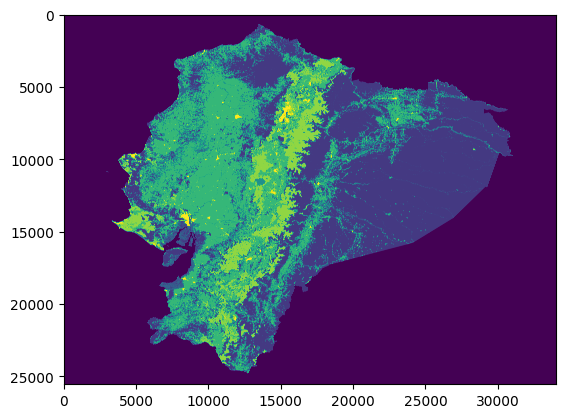

<Axes: >

In [18]:
show(labels_image)

In [19]:
dataset_rasters =  [rio.open(f'{rasters_path}/{raster}') for raster in os.listdir(rasters_path)]
print("Numero de Rasters de entrenamiento: ", len(dataset_rasters))

Numero de Rasters de entrenamiento:  21


#### Generate balanced training data

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
train_pixels = gen_balanced_pixel_locations(
    dataset_rasters,
    train_count=60000,
    label_dataset=dataset_labels,
    merge=True
)

train_count_per_dataset: 2858
points_per_class: 408
raster_points: ((564285.0, -363885.0), (792315.0, -363885.0), (792315.0, -596415.0), (564285.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:31<00:00, 13.03s/it]                 


points_per_class: 408
raster_points: ((563985.0, -363885.0), (792315.0, -363885.0), (792315.0, -596415.0), (563985.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:30<00:00, 12.87s/it]                 


points_per_class: 408
raster_points: ((562185.0, -363885.0), (790515.0, -363885.0), (790515.0, -596415.0), (562185.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:31<00:00, 13.00s/it]                 


points_per_class: 408
raster_points: ((562485.0, -363885.0), (790815.0, -363885.0), (790815.0, -596415.0), (562485.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:30<00:00, 12.89s/it]                 


points_per_class: 408
raster_points: ((562485.0, -363885.0), (790515.0, -363885.0), (790515.0, -596415.0), (562485.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:28<00:00, 12.65s/it]                 


points_per_class: 408
raster_points: ((559785.0, -363885.0), (788115.0, -363885.0), (788115.0, -596415.0), (559785.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.75s/it]                 


points_per_class: 408
raster_points: ((563085.0, -363885.0), (791415.0, -363885.0), (791415.0, -596415.0), (563085.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.75s/it]                 


points_per_class: 408
raster_points: ((560085.0, -363885.0), (788415.0, -363885.0), (788415.0, -596415.0), (560085.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.83s/it]                 


points_per_class: 408
raster_points: ((561585.0, -363885.0), (789915.0, -363885.0), (789915.0, -596415.0), (561585.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:30<00:00, 12.89s/it]                 


points_per_class: 408
raster_points: ((564585.0, -363885.0), (792615.0, -363885.0), (792615.0, -596415.0), (564585.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:28<00:00, 12.70s/it]                 


points_per_class: 408
raster_points: ((562485.0, -363885.0), (790815.0, -363885.0), (790815.0, -596415.0), (562485.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.78s/it]                 


points_per_class: 408
raster_points: ((563685.0, -363885.0), (792015.0, -363885.0), (792015.0, -596415.0), (563685.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.78s/it]                 


points_per_class: 408
raster_points: ((562785.0, -363885.0), (791115.0, -363885.0), (791115.0, -596415.0), (562785.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.72s/it]                 


points_per_class: 408
raster_points: ((561585.0, -363885.0), (789915.0, -363885.0), (789915.0, -596415.0), (561585.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:28<00:00, 12.71s/it]                 


points_per_class: 408
raster_points: ((562785.0, -363885.0), (790815.0, -363885.0), (790815.0, -596415.0), (562785.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.76s/it]                 


points_per_class: 408
raster_points: ((561285.0, -363885.0), (789615.0, -363885.0), (789615.0, -596415.0), (561285.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.80s/it]                 


points_per_class: 408
raster_points: ((563685.0, -363885.0), (791715.0, -363885.0), (791715.0, -596415.0), (563685.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.82s/it]                 


points_per_class: 408
raster_points: ((565185.0, -363885.0), (793515.0, -363885.0), (793515.0, -596415.0), (565185.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.76s/it]                 


points_per_class: 408
raster_points: ((563685.0, -363885.0), (792015.0, -363885.0), (792015.0, -596415.0), (563685.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.76s/it]                 


points_per_class: 408
raster_points: ((562785.0, -363885.0), (791115.0, -363885.0), (791115.0, -596415.0), (562785.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.78s/it]                 


points_per_class: 408
raster_points: ((562785.0, -363885.0), (791115.0, -363885.0), (791115.0, -596415.0), (562785.0, -596415.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [01:29<00:00, 12.76s/it]                 


#### Data Validation
- Balanced and accurate dataset.
- Actual pixel locations.

In [22]:
landsat_datasets = dataset_rasters
# generate the training and validation pixel locations
all_labels = []
label_locations = []
progression_bar = tqdm(train_pixels)
for index, pixel in enumerate(progression_bar):
    progression_bar.set_description("Processing data point: %s" % str(index))

    # row, col location in landsat
    r, c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(dataset_labels.crs)

    # localización geográfica
    x, y = landsat_datasets[ds_index].xy(r, c)
    # pasar de la proyección label a la proyección del mosaico
    x, y = transform(l8_proj, label_proj, x, y)
    # obtener la posición de fila y columna en la etiqueta
    r, c = dataset_labels.index(x, y)

    label_locations.append([r, c])

    # formato (bandas, altura, anchura)
    window = ((r, r+1), (c, c+1))
    data = merge_classes(dataset_labels.read(1, window=window, masked=False, boundless=True))
    all_labels.append(data[0, 0])

label_locations = np.array(label_locations)

unique, counts = np.unique(np.array(all_labels), return_counts=True)
points = [(class_names[x], counts) for x, counts in list(zip(unique, counts))]
points

Processing data point: 59975: 100%|██████████| 59976/59976 [1:16:24<00:00, 13.08it/s]


[('Sin Clasificar', 8575),
 ('Bosque', 8717),
 ('Cuerpo de Agua', 8435),
 ('Otras Tierras', 8419),
 ('Tierra Agropecuaria', 8789),
 ('Vegetacion Arbustiva y Herbacea', 8603),
 ('Zona Antropica', 8438)]

#### Visualization of Data Locations
Now display the class map along with the locations of training pixels on the image.

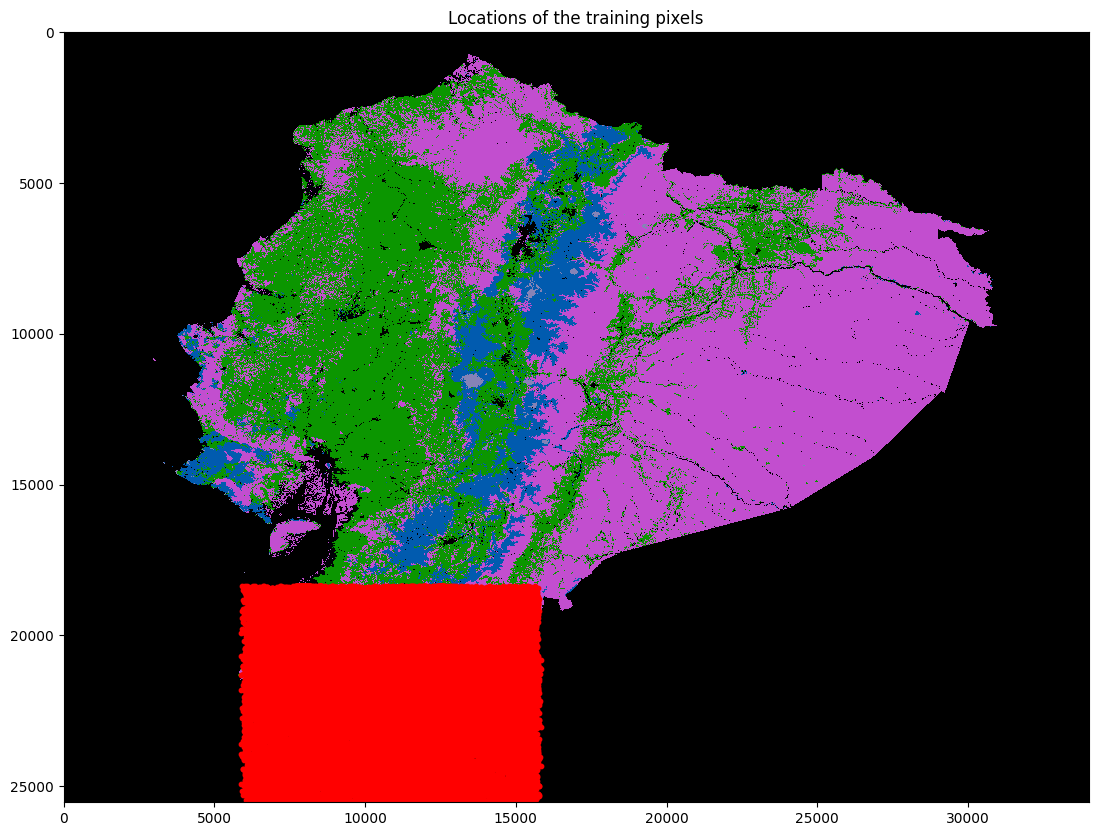

In [23]:
locations_of_pixels(labels_image, label_locations, colors_class)

#### Testing the Data Generator
Now let's test the data generator to ensure it is working correctly.

In [24]:
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, dataset_labels, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----


### Visualización de los mosaicos

Ahora vamos a visualizar los azulejos reales. Tenga en cuenta que se verán poco naturales porque han sido normalizados.

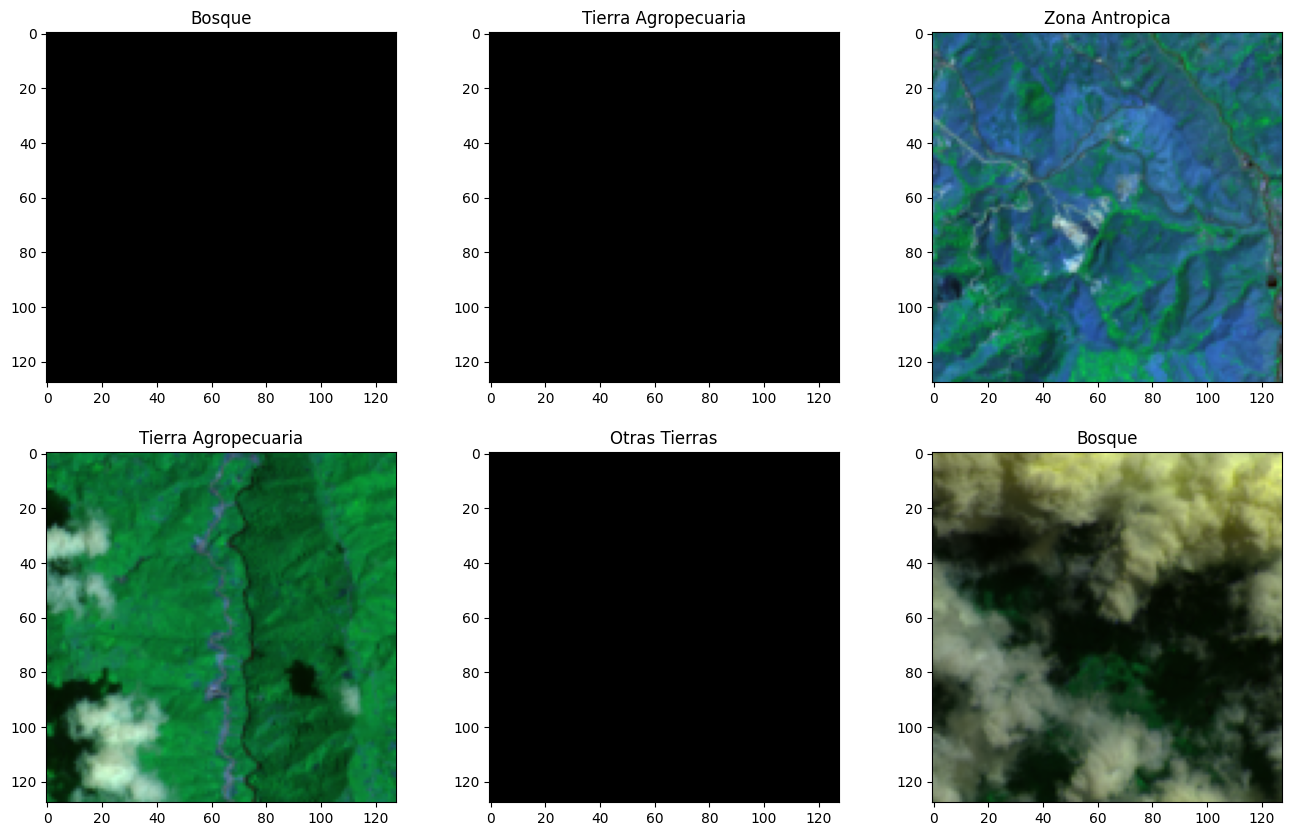

In [25]:
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))


fig, axes = plt.subplots(2, 3, figsize=(1.62*10, 10))
axes[0, 0].imshow(normalize(im_batch[0, :, :, 3:6]))
axes[0, 0].set_title(class_names[np.argmax(label_batch[0])])

axes[0, 1].imshow(normalize(im_batch[1, :, :, 3:6]))
axes[0, 1].set_title(class_names[np.argmax(label_batch[1])])

axes[0, 2].imshow(normalize(im_batch[2, :, :, 3:6]))
axes[0, 2].set_title(class_names[np.argmax(label_batch[2])])

axes[1, 0].imshow(normalize(im_batch[3, :, :, 3:6]))
axes[1, 0].set_title(class_names[np.argmax(label_batch[3])])

axes[1, 1].imshow(normalize(im_batch[4, :, :, 3:6]))
axes[1, 1].set_title(class_names[np.argmax(label_batch[4])])

axes[1, 2].imshow(normalize(im_batch[5, :, :, 3:6]))
axes[1, 2].set_title(class_names[np.argmax(label_batch[5])])

plt.show()

#### Generate 1x1 tile training dataset for scikit-learn for data visualization

In [26]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in tile_generator(dataset_rasters, dataset_labels, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 7)
----


#### Resize
Reshape because scikit-learn requires data in the `(samples, features)` format.

In [27]:
im_batch[0, :, :, :]

array([[[8.96005574, 8.36925221, 7.53971203, 7.29540176, 9.86205295,
         8.24663261, 7.24988388]]])

In [28]:
im_batch_reshaped = im_batch.reshape(sample_size, 7)
im_batch_reshaped[0]

array([8.96005574, 8.36925221, 7.53971203, 7.29540176, 9.86205295,
       8.24663261, 7.24988388])

#### Visualizing Spectral Signatures

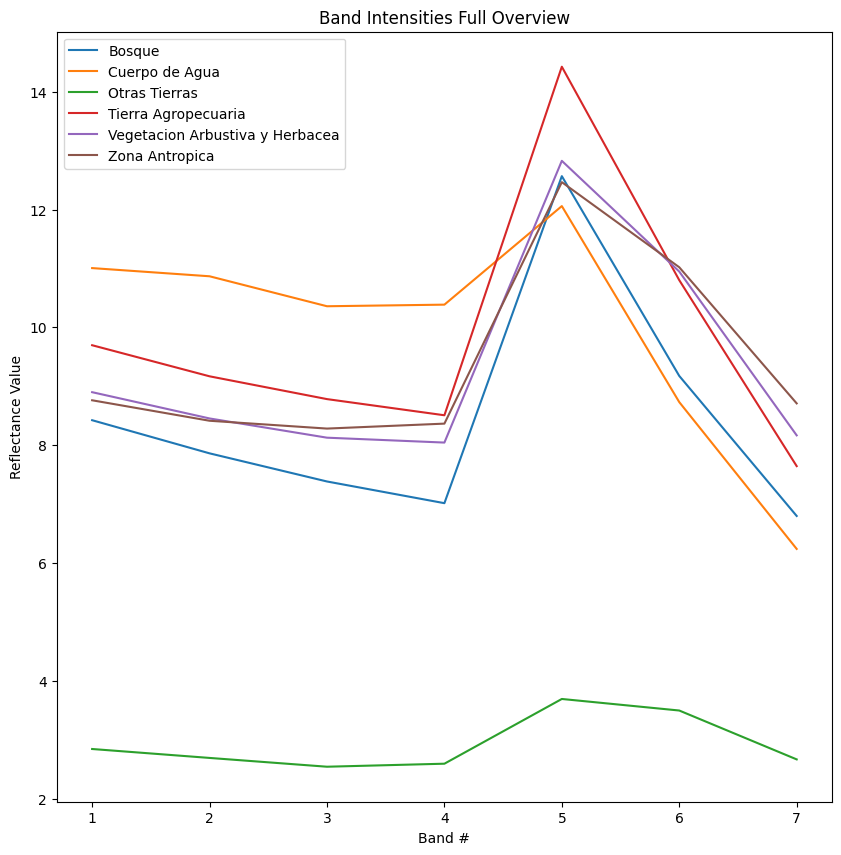

In [29]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# numbers 1-8
band_count = np.arange(1, 8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y == class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a titleA
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')

### Building the Actual Neural Network Model

In [30]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, Dropout
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay

#### Setting Hyperparameters

In [31]:
batch_size = 25
epochs = 25
num_classes = len(class_names)

# dimensiones de la imagen de entrada
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(32, 32, 7)


#### CNN Architecture

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(num_classes))
model.add(Activation('softmax'))

print("\nModel architecture:\n")
model.summary()

In [32]:
dropout_rate = 0.1
l1 = tf.keras.regularizers.l1(0)

model = Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', activity_regularizer=l1))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(3200, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

print("\nModel architecture:\n")
model.summary()

2023-06-05 12:51:16.596797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 12:51:16.597193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 12:51:16.597363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 12:51:16.597854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 12:51:16.598056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S


Model architecture:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 7)        28        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4096      
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                  

#### Metrics and Model Compilation

In [33]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.0003), metrics=['accuracy'])

#### Splitting the Data into Training and Validation

In [34]:
train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("# Training samples: {n_training} \n# Validation samples: {n_val}".format(n_training=len(train_px), n_val=len(val_px)))

# Training samples: 47980 
# Validation samples: 11996


In [35]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95):
            print("\n Se ha alcanzado el umbral PRESICION. Entrenamiento detenido.....")
            self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [36]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='../reports/logs/landsat')

history = model.fit(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size, merge=True
    ),
    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
    validation_data=tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True),
    validation_steps=len(val_px) // batch_size,
    callbacks=[early_stopping, tensorboard]
)

Epoch 1/25


2023-06-05 12:51:20.620665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-06-05 12:51:21.516924: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-05 12:51:21.794541: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1919/1919 [==============================] - 5278s 3s/step - loss: 1.4350 - accuracy: 0.4309 - val_loss: 1.3043 - val_accuracy: 0.4899
Epoch 2/25
1919/1919 [==============================] - 5630s 3s/step - loss: 1.2757 - accuracy: 0.4954 - val_loss: 1.2261 - val_accuracy: 0.5114
Epoch 3/25
1919/1919 [==============================] - 6055s 3s/step - loss: 1.1953 - accuracy: 0.5270 - val_loss: 1.2087 - val_accuracy: 0.5359
Epoch 4/25
1919/1919 [==============================] - 6698s 3s/step - loss: 1.1015 - accuracy: 0.5638 - val_loss: 1.2830 - val_accuracy: 0.5165
Epoch 5/25
1919/1919 [==============================] - 7201s 4s/step - loss: 0.9647 - accuracy: 0.6189 - val_loss: 1.5901 - val_accuracy: 0.4980
Epoch 6/25
1919/1919 [==============================] - 7539s 4s/step - loss: 0.8394 - accuracy: 0.6710 - val_loss: 1.8091 - val_accuracy: 0.5053
Epoch 7/25
1919/1919 [==============================] - 7611s 4s/step - loss: 0.7377 - accuracy: 0.7093 - val_loss: 1.9121 - val_accura

#### Saving the Trained Model

In [37]:
save_path = '../models/landsat/'
model.save(f"{save_path}model_v1.h5")
print("Saved model to disk")

Saved model to disk


#### Visualization of Training and Validation Curves

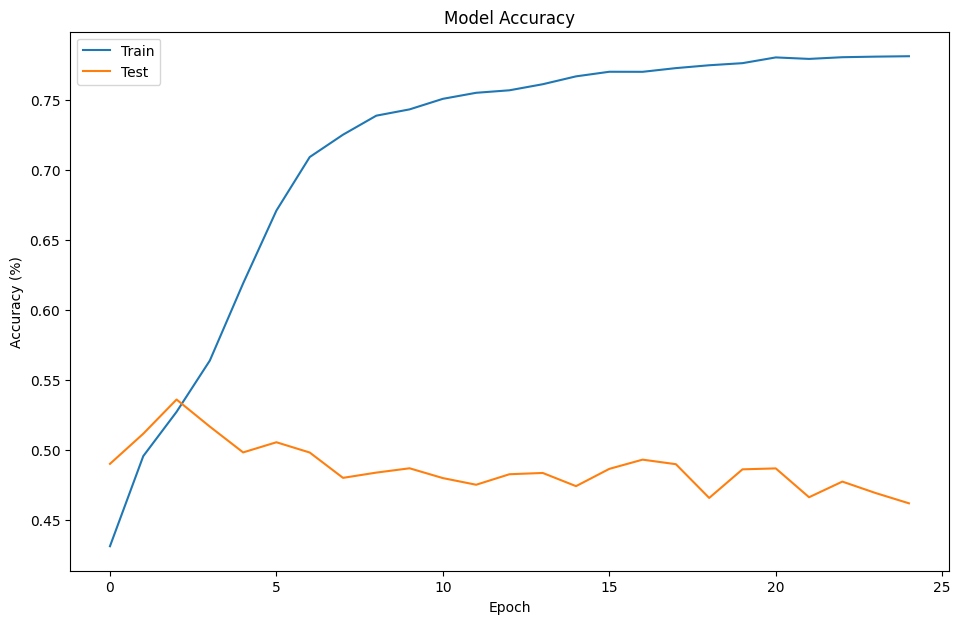

In [38]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Test'], loc='upper left')

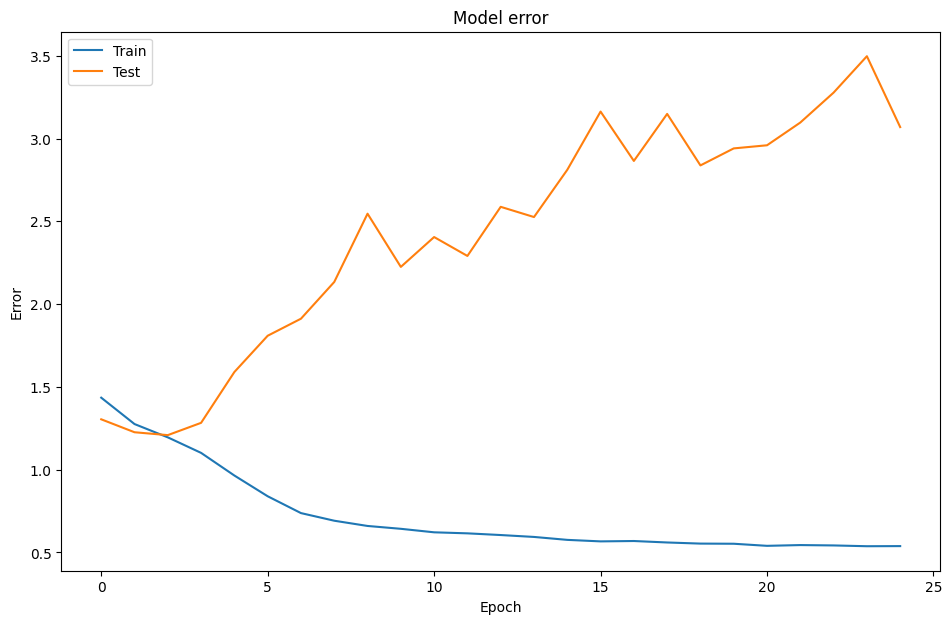

In [39]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model error")
plt.ylabel("Error")
plt.xlabel("Epoch")
_ = plt.legend(['Train', 'Test'], loc='upper left')

#### Check Test Accuracy Based on Confusion Matrix

In [40]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True
    ),
    steps=len(val_px) // batch_size,
    verbose=1
)

479/479 [==============================] - 954s 2s/step


In [41]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    val_px,
    batch_size=1,
    merge=True
)

In [42]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Plotting Unnormalized Confusion Matrix

In [8]:
plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names
)

NameError: name 'label_index' is not defined

#### Plotting Normalized Confusion Matrix

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names,
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

### Checking Training Accuracy Based on Confusion Matrix

In [ ]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size,
        merge=True
    ),
    steps=len(train_px) // batch_size,
    verbose=1
)

In [ ]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    train_px,
    batch_size=1,
    merge=True
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Plotting Unnormalized Confusion Matrix

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names
)

#### Plotting Normalized Confusion Matrix

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names,
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

In [ ]:
print("IPython Notebook execution completed!")

In [7]:
new_model = tf.keras.models.load_model('../models/landsat/model_v1.h5')

# Check its architecture
new_model.summary()

2023-06-08 16:17:18.641833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 16:17:18.748146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 16:17:18.748453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 16:17:18.749058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 7)        28        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4096      
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                        